In [1]:
import pandas as pd

tic='gold'
pd.set_option('display.max_columns', 25) 

# Location of dataset
#file = "C:\\Users\\KocurLocur\\Desktop\\jupyter\\TT_dax_data_new.txt"
file = "http://bpk.nazwa.pl/111/test.php?tic="+tic
TT_days=100
pred_data=35

load_dict={}

load_dict['dax']=('dax_20190530_62_15_16_915_short','dax_20190530_59_12_13_1056_short','dax_20190530_57_10_14_1046_short',
                 'dax_20190530_56_9_8_1331_short','dax_20190530_64_14_9_1163_short','dax_20190530_61_8_7_1280_short',
                 'dax_20190530_43_7_8_1137_short','dax_20190530_69_21_24_812_short','dax_20190530_56_4_7_1328_short',
                 'dax_20190530_73_21_15_1049_short','dax_20190530_73_19_12_1077_short')

load_dict['dji']=('dji_20190601_29_9_1_1178_short','dji_20190601_30_2_3_1459_short','dji_20190601_41_16_17_679_short',
                  'dji_20190601_38_10_12_830_short','dji_20190601_30_11_6_836_short','dji_20190601_32_16_6_824_short',
                 'dji_20190601_35_12_9_819_short','dji_20190601_37_12_3_1166_short','dji_20190601_34_8_5_1000_short',
                 'dji_20190601_27_11_2_1011_short','dji_20190601_33_10_1_1212_short')

load_dict['nasdaq']=('nasdaq_20190531_74_9_22_952_short','nasdaq_20190531_72_13_24_869_short','nasdaq_20190531_66_7_11_1370_short',
                    'nasdaq_20190531_68_10_17_1069_short','nasdaq_20190531_70_10_25_886_short','nasdaq_20190531_74_14_14_832_short',
                    'nasdaq_20190531_74_13_17_1040_short','nasdaq_20190531_71_9_9_1132_short','nasdaq_20190531_73_2_21_1135_short',
                    'nasdaq_20190531_77_16_18_991_short','nasdaq_20190531_83_10_19_1116_short')

load_dict['gold']=('gold_20190530_120_32_27_989_short','gold_20190530_114_35_16_1090_short','gold_20190530_125_26_31_1000_short',
                   'gold_20190530_116_24_26_1022_short','gold_20190530_110_19_22_1095_short','gold_20190530_148_36_40_949_short',
                  'gold_20190530_132_32_28_1029_short','gold_20190530_93_24_31_877_short','gold_20190530_111_21_27_985_short',
                   'gold_20190530_119_26_24_1102_short','gold_20190530_104_34_36_722_short')

load_dict['brent']=('brent_20190530_150_13_49_855_short','brent_20190530_141_17_40_747_short','brent_20190530_142_12_38_954_short',
                   'brent_20190530_144_13_34_975_short','brent_20190530_141_13_42_961_short','brent_20190530_167_17_69_709_short',
                   'brent_20190530_191_21_68_812_short','brent_20190530_156_6_45_1012_short','brent_20190530_155_22_62_706_short',
                   'brent_20190530_156_21_53_746_short','brent_20190530_166_10_44_919_short')

In [2]:
# Assign colum names to the dataset
names = ['Date', 'Price', 'Vol', 'T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11']
# Read dataset to pandas dataframe
df = pd.read_csv(file, names=names) 
#Check dayWeek
df['Date']=pd.to_datetime(df['Date'])
df['D']=df['Date'].dt.dayofweek
df.iloc[:,2:15]=df.iloc[:,2:15].astype(float)

In [3]:
#count percentage volume from day before
df['Vol']=df['Vol'].apply(pd.to_numeric, errors='coerce')


if (tic=='gold' or tic=='brent'):
    df['%_v1']=0.0
else:
    df['%_v1']=100*(1-df['Vol'].shift(-1)/df['Vol'])
    df['%_v1']=df['%_v1'].apply(pd.to_numeric, errors='coerce')

#df

In [4]:
#shift values
for y in range(1,TT_days+1):
    for x in range (1,12):
        df['T'+str(x)+'_'+str(y)]=df['T'+str(x)].shift(-y) 

In [5]:
import numpy as np
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna()

In [6]:
X_test = df.iloc[0:pred_data, 3:(16+11*TT_days)]

In [7]:
from joblib import dump,load
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


predict=[]
for loading in load_dict[tic]:
    scala=(load(loading+'_scaler.joblib'))
    mlp=(load(loading+'_mlp.joblib'))
    X_test_scaled=scala.transform(X_test)
    predict.append(mlp.predict(X_test_scaled))
clf=(load(tic+'_forest.joblib'))
dec_forest=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [8]:
df_new = pd.DataFrame() 
df_new['Date']=df['Date'].head(pred_data)

pred=0
for i in range(len(predict)):
    df_new['P'+str(i)]=predict[i]
    pred +=predict[i]
pred=pred/(i+1)

df_new['sum_-1'] = (df_new.iloc[:,1:12] == -1).sum(axis=1)
df_new['sum_0'] = (df_new.iloc[:,1:12] == 0).sum(axis=1)
df_new['sum_1'] = (df_new.iloc[:,1:12] == 1).sum(axis=1)
df_new['sum_2'] = (df_new.iloc[:,1:12] == 2).sum(axis=1)
df_new['y']=0

df_new['Pred']=-pred
df_new['Pred']=df_new.iloc[0:pred_data,1:12].mode(axis=1)[0]
df_new['Forest']=dec_forest

df_new['Signal']='---'

df_new.loc[((df_new['sum_-1'] >=8)), 'Signal'] = 'Buy S'
df_new.loc[((df_new['sum_1'] >=8)), 'Signal'] = 'Sell S'
df_new['Price']=df['Price']

for y in range(1,6):
    df_new['%_p'+str(y)]=100*(1-df_new['Price'].shift(y)/df_new['Price'])

df_new['PriceN']=(df['Price'].head(pred_data)-df['Price'].head(pred_data).mean())/(df['Price'].head(pred_data).max()-df['Price'].head(pred_data).min())
df_new['PredN']=-(df_new['Pred'].head(pred_data)-df_new['Pred'].head(pred_data).mean())/(df_new['Pred'].head(pred_data).max()-df_new['Pred'].head(pred_data).min())


In [9]:
df_new['Max']=df_new[["%_p1", "%_p2","%_p3","%_p4","%_p5"]].max(axis=1)
df_new['Min']=df_new[["%_p1", "%_p2","%_p3","%_p4","%_p5"]].min(axis=1)

df_new.loc[(df_new['Min'] <=-1), 'y'] = 1
df_new.loc[(df_new['Max'] >=2 ), 'y'] = -1
df_new.loc[(df_new['Max'] >=2 ) & (df_new['Min'] <=-1 ), 'y'] = 2

df_new['yN']=-(df_new['y'].head(pred_data)-df_new['y'].head(pred_data).mean())/(df_new['y'].head(pred_data).max()-df_new['y'].head(pred_data).min())

df_new.iloc[0:30,0:25].round(1)

,Date,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,sum_-1,sum_0,sum_1,sum_2,y,Pred,Forest,Signal,Price,%_p1,%_p2,%_p3,%_p4
0,2019-10-07,0,0,1,1,1,0,0,0,1,0,1,0,6,5,0,0,0,0,---,1512.4,NaN,NaN,NaN,NaN
1,2019-10-04,1,1,1,1,1,1,1,1,1,0,1,0,1,10,0,0,1,0,Sell S,1515.8,0.2,NaN,NaN,NaN
2,2019-10-03,1,1,1,1,1,1,1,1,1,0,1,0,1,10,0,0,1,0,Sell S,1504.7,-0.7,-0.5,NaN,NaN
3,2019-10-02,0,1,1,1,1,1,1,1,0,0,1,0,3,8,0,1,1,0,Sell S,1483.2,-1.4,-2.2,-2.0,NaN
4,2019-10-01,1,1,1,1,1,1,1,1,1,0,1,0,1,10,0,1,1,0,Sell S,1469.4,-0.9,-2.4,-3.2,-2.9
5,2019-09-30,1,1,1,1,1,1,1,1,1,0,1,0,1,10,0,1,1,0,Sell S,1498.4,1.9,1.0,-0.4,-1.2
6,2019-09-27,1,1,1,0,1,1,1,1,1,0,1,0,2,9,0,-1,1,0,Sell S,1514.0,1.0,2.9,2.0,0.6
7,2019-09-26,0,1,1,0,1,0,0,1,0,0,1,0,6,5,0,-1,0,0,---,1515.8,0.1,1.1,3.1,2.2
8,2019-09-25,1,1,1,0,1,0,1,0,0,0,1,0,5,6,0,-1,1,0,---,1537.2,1.4,1.5,2.5,4.4
9,2019-09-24,1,1,1,0,1,1,1,1,1,0,1,0,2,9,0,-1,1,0,Sell S,1528.4,-0.6,0.8,0.9,2.0


In [10]:
df_new.iloc[:30,:].plot(x='Date', y=['sum_-1','sum_0','sum_1','sum_2'],figsize=(20,3),grid=True,sharex=True,sharey=True)

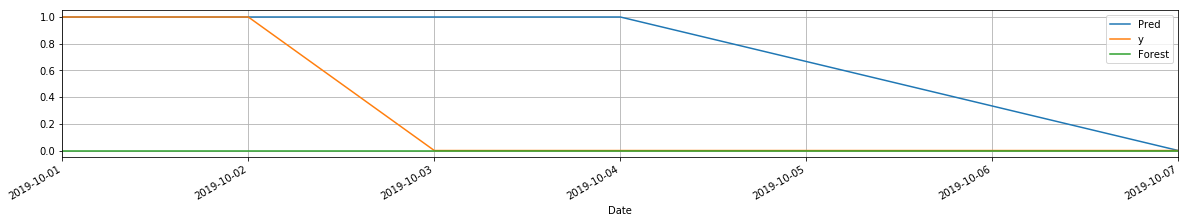

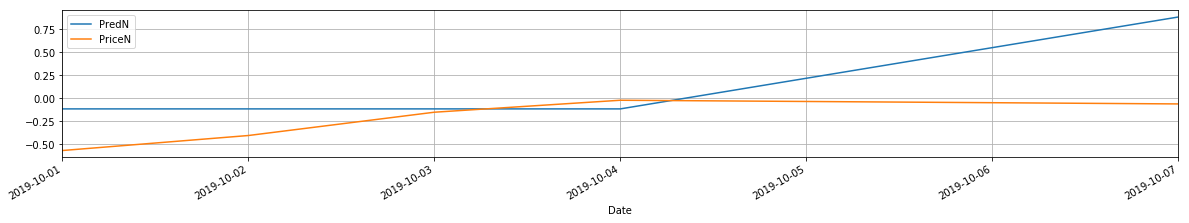

In [11]:
df_new.iloc[:5,:].plot(x='Date', y=['Pred','y','Forest'],figsize=(20,3),grid=True)
df_new.iloc[:5,:].plot(x='Date', y=['PredN','PriceN'],figsize=(20,3),grid=True)

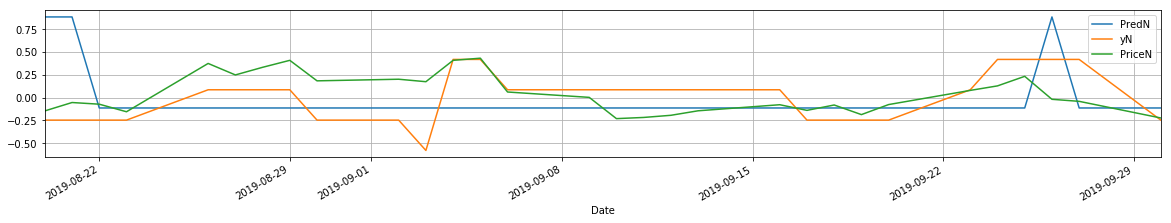

In [12]:
df_new.iloc[5:,:].plot(x='Date', y=['PredN','yN','PriceN'],figsize=(20,3),grid=True,sharex=True,sharey=True)

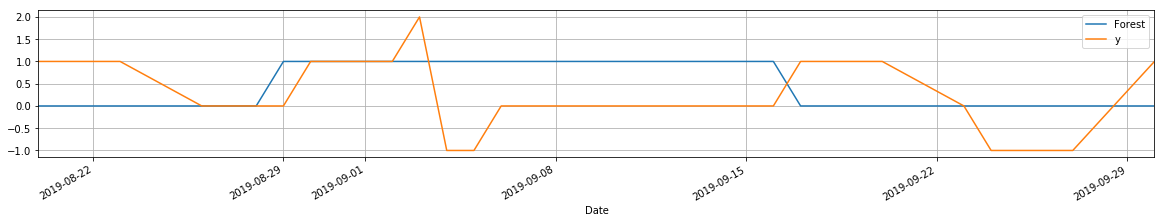

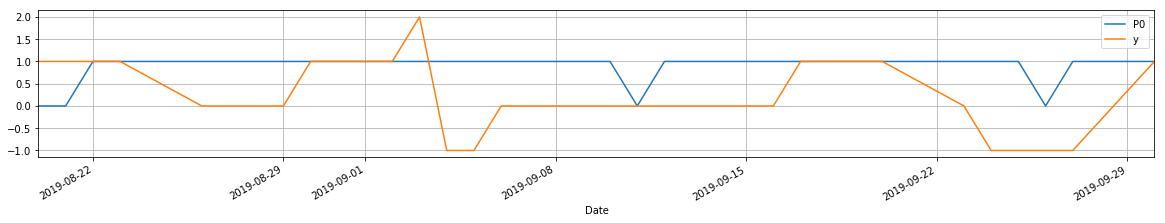

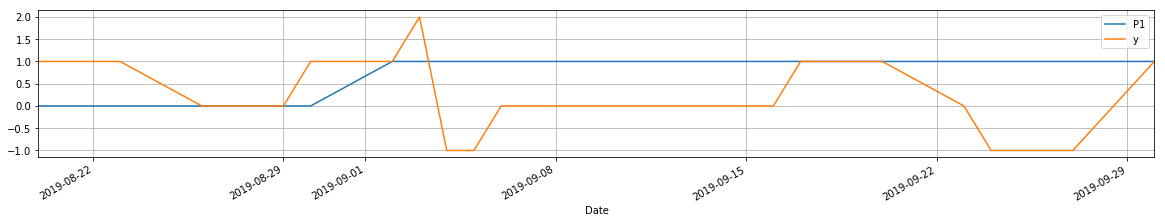

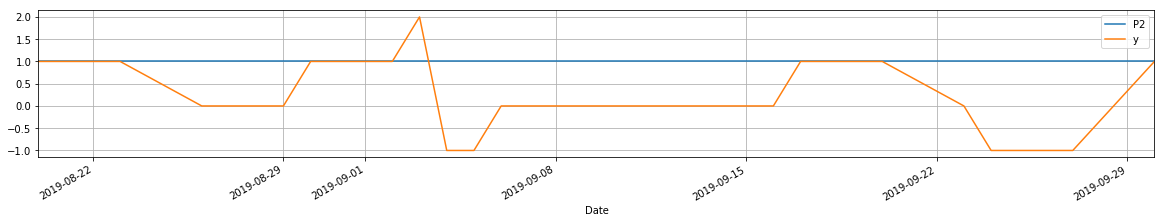

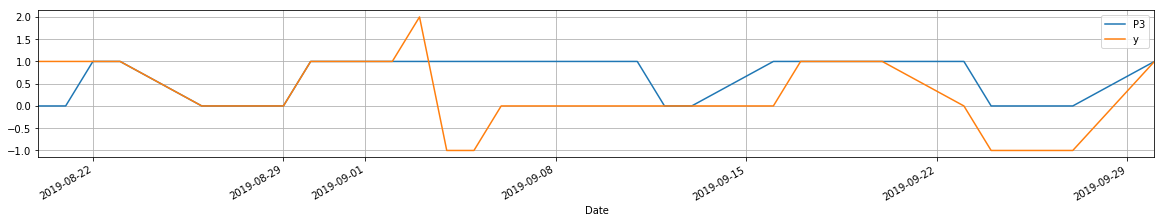

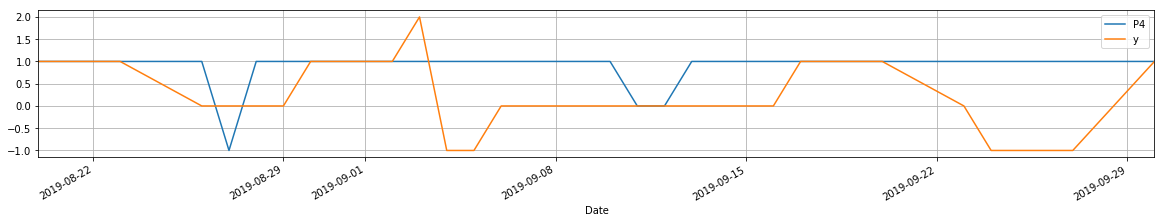

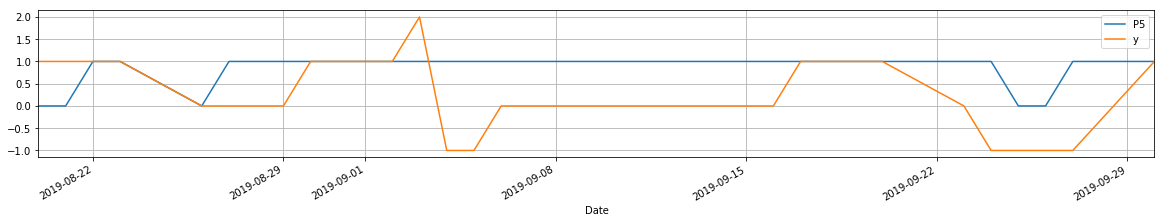

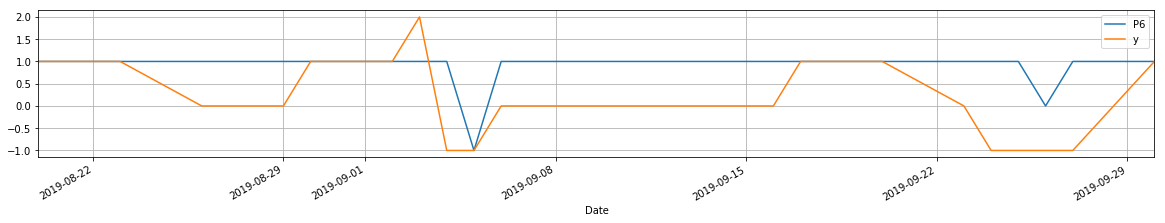

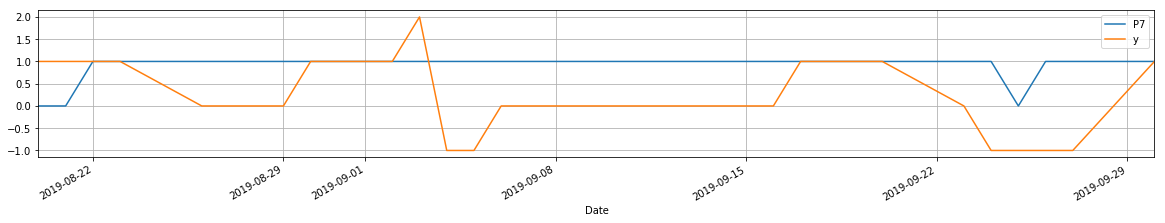

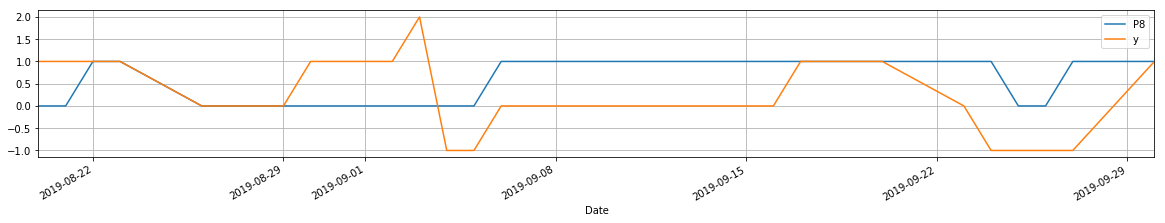

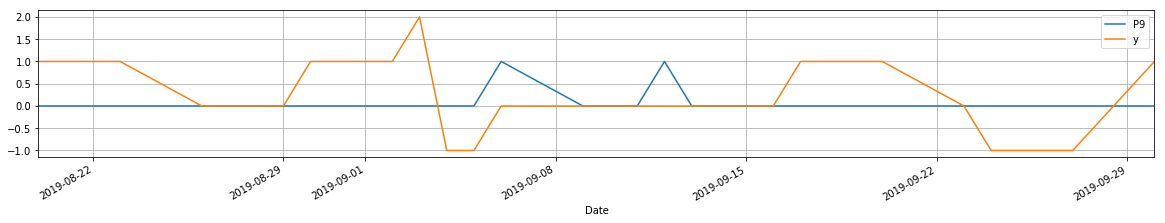

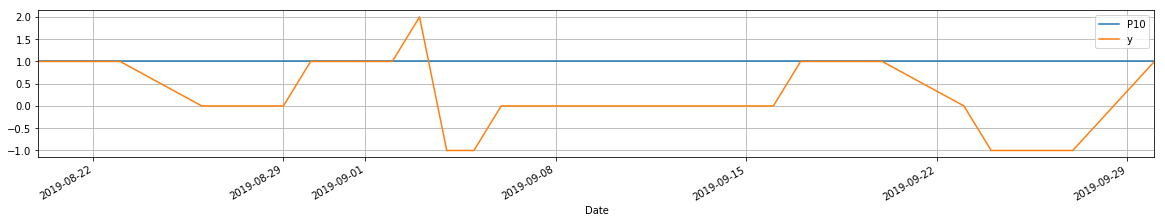

In [13]:
df_new.iloc[5:,:].plot(x='Date', y=['Forest','y'],figsize=(20,3),grid=True,sharey=True)
for i in range(0,len(load_dict[tic])):
    df_new.iloc[5:,:].plot(x='Date', y=['P'+str(i),'y'],figsize=(20,3),grid=True,sharey=True)

In [14]:
from statsmodels.stats.stattools import jarque_bera
import numpy as np
jarque_bera(np.random.normal(0, 1, 10000))

(3.828545748317029, 0.1474490076003063, -0.04738109328610836, 3.01444429963734)